# Explainable AI project - Part 1 : Training
### Randomized Input Sampling for Explanation of Black-box Models : **RISE**
An implementation on [Imagenette](https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz) a subset of ImageNet with 10 classes.

## 1. Models Training

#### 1. Imagenette dataset

In [1]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz > /dev/null 2>&1
!tar zxvf imagenette2.tgz > /dev/null 2>&1

In [2]:
import torchvision
import torchvision.transforms as transforms
import torch
import os
from torch.utils.data import Dataset


means, stds = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds),
    ])

test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds),
    ])

def get_imagenette2_loaders(root_path='./imagenette2', **kwargs):

    trainset = torchvision.datasets.ImageFolder(os.path.join(root_path, "train"), transform=train_transform)
    trainloader = torch.utils.data.DataLoader(trainset, **kwargs)
    testset = torchvision.datasets.ImageFolder(os.path.join(root_path, "val"), transform=test_transform)
    testloader = torch.utils.data.DataLoader(testset, **kwargs)
    return trainloader, testloader

trainloader, testloader = get_imagenette2_loaders( batch_size=64, shuffle=True, num_workers=2)

labels = ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']

(-0.5, 1809.5, 1357.5, -0.5)

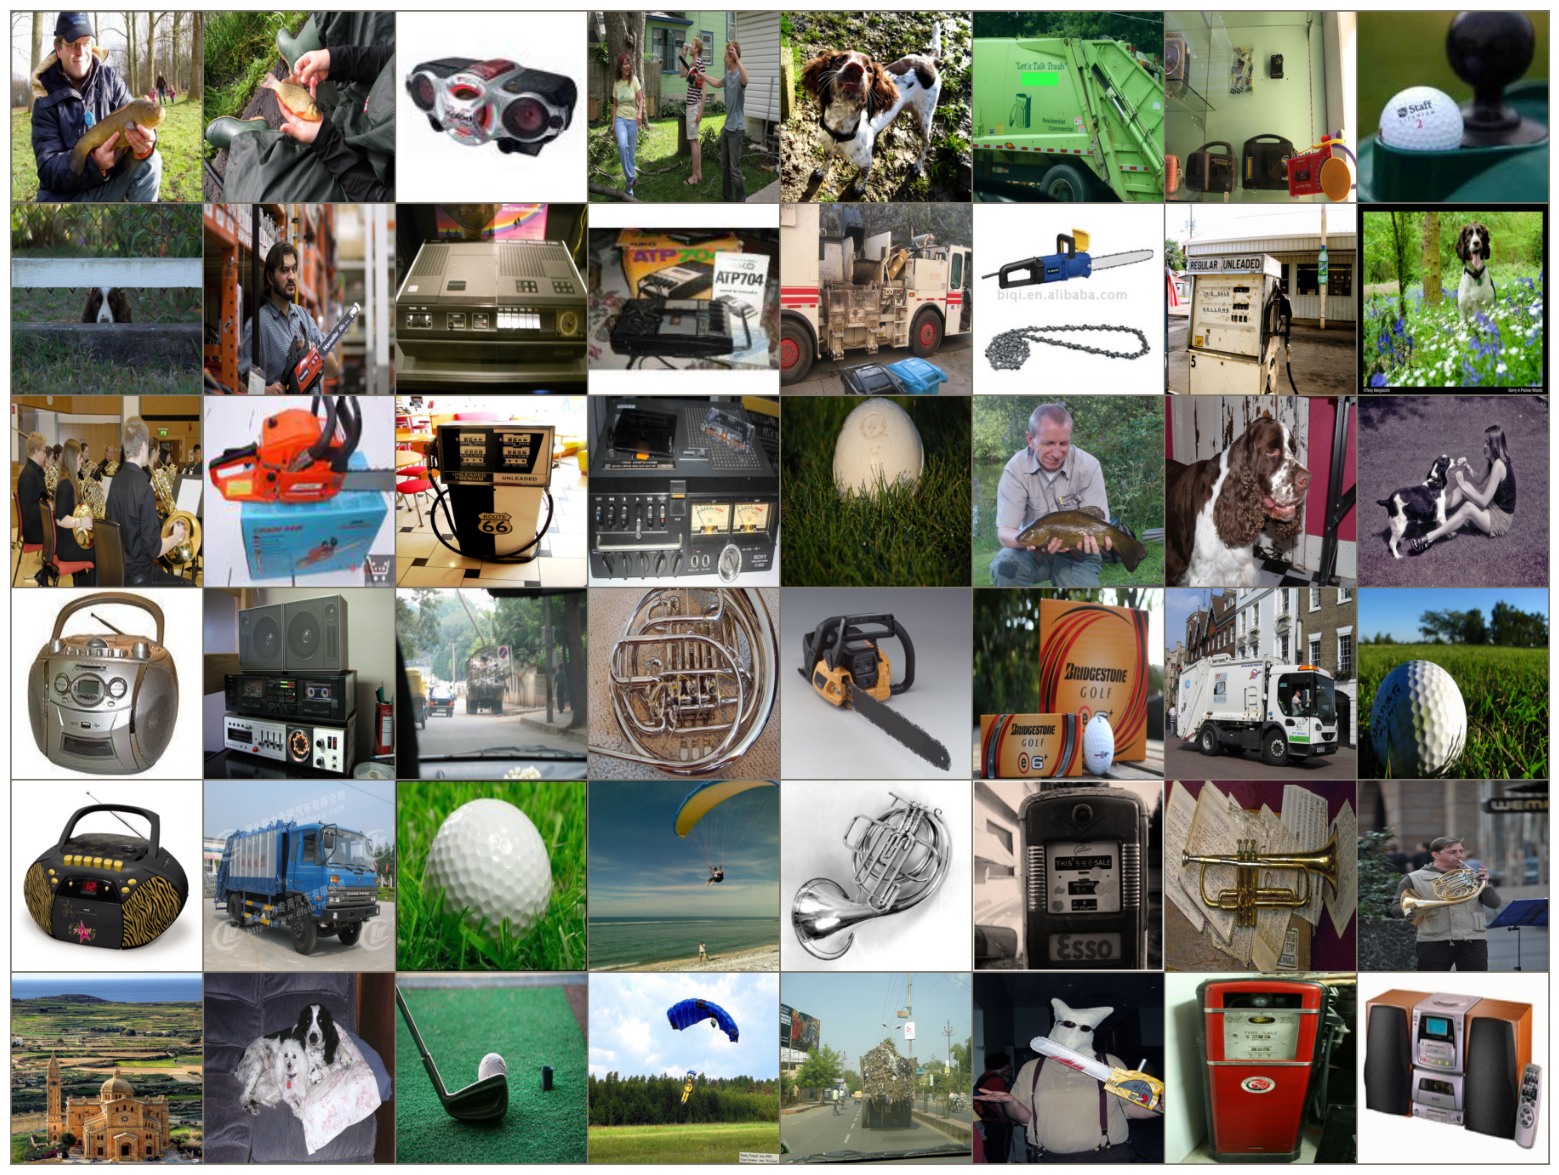

In [3]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(means, stds)],
   std= [1/s for s in stds]
)

x, _ = next(iter(trainloader))
img_grid = make_grid(x[:48])
img_grid = inv_normalize(img_grid)
plt.figure(figsize=(20,15))
plt.imshow(img_grid.permute(1, 2, 0))
plt.axis('off')

#### 2. Models

We choosed two models for the predictions on the Imagenette dataset.

##### 1. ResNet-34 pretrained on ImageNet-1k from [Microsoft](https://huggingface.co/microsoft/resnet-34)
for more informations, consult [*Deep residual learning for image recognition*](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf), He, Kaiming and Zhang, Xiangyu and Ren, Shaoqing and Sun, Jian, 2016

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=512, out_features=10, bias=True)
)
4
church


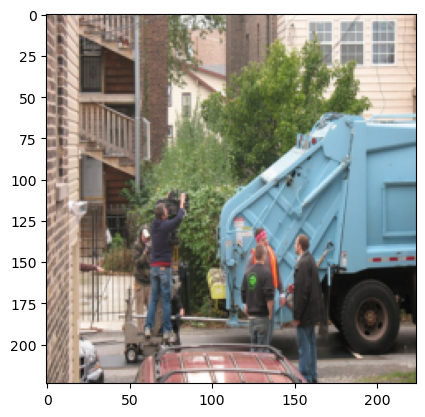

In [5]:
from transformers import AutoFeatureExtractor, ResNetForImageClassification
import torch.nn as nn


x, _ = next(iter(trainloader))
image = inv_normalize(x[0])
plt.imshow(inv_normalize(x[0]).permute(1, 2, 0))

feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-34")
model_resnet = ResNetForImageClassification.from_pretrained("microsoft/resnet-34")

# Modify the classification layer to have 10 classes
num_features = model_resnet.classifier[1].in_features

classifier = nn.Sequential(
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(num_features, 10)
)

model_resnet.classifier = classifier
print(model_resnet.classifier)

with torch.no_grad():
    logits = model_resnet(image.unsqueeze_(0)).logits

# model predicts one of the 10 classes
predicted_label = logits.argmax(-1).item()
print(predicted_label)
print(labels[predicted_label])


##### 2. MobileOne-s1 from [Apple mobile backbone](https://github.com/apple/ml-mobileone)
for more informations, consult [*An Improved One millisecond Mobile Backbone*](https://arxiv.org/pdf/2206.04040), Vasu, Pavan Kumar Anasosalu and Gabriel, James and Zhu, Jeff and Tuzel, Oncel and Ranjan, Anurag, 2022

7
gas pump


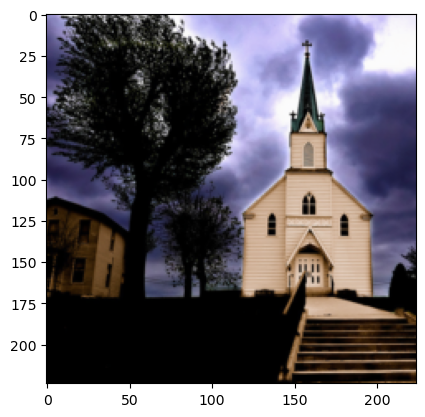

In [6]:
from mobileone import mobileone, reparameterize_model

x, _ = next(iter(trainloader))
image = inv_normalize(x[0])
plt.imshow(inv_normalize(x[0]).permute(1, 2, 0))

# Load Pre-trained checkpoint for fine-tuning
model_mobileone = mobileone(variant='s1')
checkpoint = torch.load('mobileone_s1_unfused.pth.tar', map_location=torch.device('cpu'))
model_mobileone.load_state_dict(checkpoint)

# Change the number of classes in the linear layer to 10
model_mobileone.linear = nn.Linear(in_features=model_mobileone.linear.in_features, out_features=10)

# For inference
model_mobileone.eval()
model_mobileone_eval = reparameterize_model(model_mobileone)

with torch.no_grad():
    logits = model_mobileone_eval(image.unsqueeze_(0))

# model predicts one of the 10 classes
predicted_label = logits.argmax(-1).item()
print(predicted_label)
print(labels[predicted_label])

#### 3. Training

##### 1. ResNet-34

In [7]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

# Freeze all parameters except the classifier
for name, param in model_resnet.named_parameters():
    if "classifier" not in name:  # Exclude classifier parameters
        param.requires_grad = False

# We only train classifier parameters
optimizer = optim.Adam(model_resnet.classifier.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10], gamma=0.1)
criterion = nn.CrossEntropyLoss()

# Train the classifier
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model_resnet.to(device)
model_resnet.train()

losses = []
losses_test = []

print('training ...')

for epoch in range(num_epochs):
    running_loss = 0
    # ------------ Training -------------
    for images, labels in tqdm(trainloader):
        images, labels = images.to(device), labels.to(device)
        # One hot labels vector encoding
        one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=10).float()

        optimizer.zero_grad()
        outputs = model_resnet(images)

        loss = criterion(outputs.logits, one_hot_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    losses.append(epoch_loss)

    # ------------ Testing -------------
    with torch.no_grad():
        for images, labels in tqdm(testloader):
            images, labels = images.to(device), labels.to(device)
            # One hot labels vector encoding
            one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=10).float()

            outputs = model_resnet(images)

            loss = criterion(outputs.logits, one_hot_labels)

            running_loss += loss.item()

        epoch_loss_test = running_loss / len(testloader)
        losses_test.append(epoch_loss_test)
    
    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss}, Test Loss : {epoch_loss_test}")
    scheduler.step()

cpu
training ...


100%|██████████| 62/62 [01:46<00:00,  1.72s/it]


Epoch 1, Train Loss: 0.4385979759532052, Test Loss : 1.1928362855387311


100%|██████████| 62/62 [01:41<00:00,  1.64s/it]


Epoch 2, Train Loss: 0.11891392448514297, Test Loss : 0.39522066282769364


100%|██████████| 62/62 [01:41<00:00,  1.64s/it]


Epoch 3, Train Loss: 0.08504418048353211, Test Loss : 0.29595725818146623


100%|██████████| 62/62 [01:41<00:00,  1.64s/it]


Epoch 4, Train Loss: 0.06936261406470393, Test Loss : 0.2512972294803589


100%|██████████| 62/62 [01:41<00:00,  1.63s/it]


Epoch 5, Train Loss: 0.05917887604241637, Test Loss : 0.2306754149706854


100%|██████████| 62/62 [01:41<00:00,  1.64s/it]


Epoch 6, Train Loss: 0.048508631726223474, Test Loss : 0.2023723819893935


100%|██████████| 62/62 [01:41<00:00,  1.64s/it]


Epoch 7, Train Loss: 0.04754892372954134, Test Loss : 0.19690829673181137


100%|██████████| 62/62 [01:48<00:00,  1.75s/it]


Epoch 8, Train Loss: 0.04321077001293668, Test Loss : 0.18268551273391612


100%|██████████| 62/62 [01:41<00:00,  1.64s/it]


Epoch 9, Train Loss: 0.03775231255142874, Test Loss : 0.17378559360100376


100%|██████████| 62/62 [01:42<00:00,  1.65s/it]


Epoch 10, Train Loss: 0.034842428584532764, Test Loss : 0.16404553038638928


100%|██████████| 62/62 [01:42<00:00,  1.65s/it]


Epoch 11, Train Loss: 0.032693468617917214, Test Loss : 0.15470168013651406


100%|██████████| 62/62 [01:48<00:00,  1.75s/it]


Epoch 12, Train Loss: 0.029484088273051923, Test Loss : 0.1471660744902047


100%|██████████| 62/62 [01:41<00:00,  1.64s/it]


Epoch 13, Train Loss: 0.02893697240270322, Test Loss : 0.14635272540767946


100%|██████████| 62/62 [01:41<00:00,  1.64s/it]


Epoch 14, Train Loss: 0.026513967606415216, Test Loss : 0.1336322231819072


100%|██████████| 62/62 [01:41<00:00,  1.64s/it]


Epoch 15, Train Loss: 0.02700233775052569, Test Loss : 0.13843104454328217


100%|██████████| 62/62 [01:41<00:00,  1.64s/it]


Epoch 16, Train Loss: 0.02851349952539454, Test Loss : 0.14304204268433574


100%|██████████| 62/62 [01:41<00:00,  1.63s/it]


Epoch 17, Train Loss: 0.02594744991133543, Test Loss : 0.13992676756254607


100%|██████████| 62/62 [01:48<00:00,  1.74s/it]


Epoch 18, Train Loss: 0.027621609674817003, Test Loss : 0.1429842194362033


100%|██████████| 62/62 [01:41<00:00,  1.64s/it]


Epoch 19, Train Loss: 0.025571232428774238, Test Loss : 0.14134201270738436


100%|██████████| 62/62 [01:41<00:00,  1.64s/it]

Epoch 20, Train Loss: 0.027356981293524842, Test Loss : 0.14266139316943385


In [15]:
accuracy_test = 0

with torch.no_grad():
    for images, labels in tqdm(testloader):
        images, labels = images.to(device), labels.to(device)

        outputs = model_resnet(images)
        max_indices = torch.argmax(outputs.logits, dim=1)

        accuracy_test += torch.sum(torch.eq(max_indices, labels)).item()

    accuracy_test = accuracy_test / (64 * len(testloader))

print(f"Test Accuracy : {accuracy_test}")

100%|██████████| 62/62 [01:47<00:00,  1.74s/it]

Test Accuracy : 0.9632056451612904


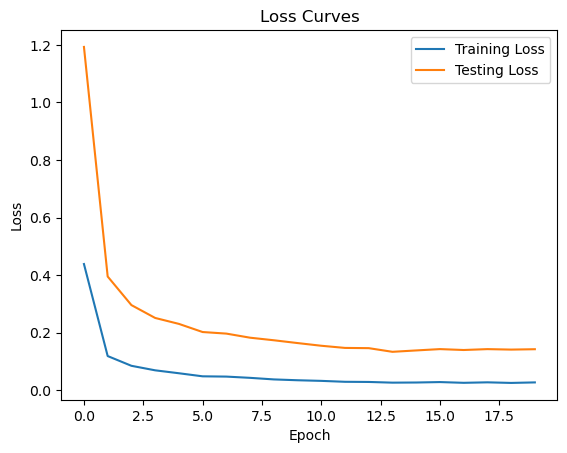

In [9]:
# Plot the loss curve
plt.plot(losses, label='Training Loss')
plt.plot(losses_test, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

In [10]:
torch.save(model_resnet.state_dict(), "resnet_34_10_classes_v4.pth")

#V1 = Adam + transfer learning + 2 epochs
#V2 = Adam + transfer learning + 10 epochs
#V3 = Adam + transfer learning + 10 epochs (testing implementation)
#V4 = Adam + transfer learning + 20 epochs + scheduler (at 10, lr/10)

##### 2. MobileOne

In [11]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn

# Freeze the parameters of all layers
for param in model_mobileone.parameters():
    param.requires_grad = False

# Make the parameters of the linear layer trainable
for param in model_mobileone.linear.parameters():
    param.requires_grad = True

# We only train classifier parameters
optimizer = optim.Adam(model_mobileone.linear.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train the classifier
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model_mobileone.to(device)
model_mobileone.train()

losses = []
losses_test = []

print('training ...')

for epoch in range(num_epochs):
    running_loss = 0
    for images, labels in tqdm(trainloader):
        images, labels = images.to(device), labels.to(device)
        # One hot labels vector encoding
        one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=10).float()

        optimizer.zero_grad()

        outputs = model_mobileone(images)
        loss = criterion(outputs, one_hot_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    losses.append(epoch_loss)

    # ------------ Testing -------------
    with torch.no_grad():
        for images, labels in tqdm(testloader):
            images, labels = images.to(device), labels.to(device)
            # One hot labels vector encoding
            one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=10).float()

            outputs = model_mobileone(images)

            loss = criterion(outputs, one_hot_labels)

            running_loss += loss.item()

        epoch_loss_test = running_loss / (len(testloader)*64)
        losses_test.append(epoch_loss_test)
    
    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss}, Test Loss : {epoch_loss_test}")
    scheduler.step()

cpu
training ...


100%|██████████| 62/62 [03:40<00:00,  3.56s/it]


Epoch 1, Train Loss: 0.3848443142062909, Test Loss : 0.016362361593975597


100%|██████████| 62/62 [03:41<00:00,  3.58s/it]


Epoch 2, Train Loss: 0.09194804811095064, Test Loss : 0.00477238780219904


100%|██████████| 62/62 [03:44<00:00,  3.62s/it]


Epoch 3, Train Loss: 0.06411562092929475, Test Loss : 0.003446086956941027


100%|██████████| 62/62 [03:55<00:00,  3.80s/it]


Epoch 4, Train Loss: 0.05060236643043321, Test Loss : 0.0029287162472047064


100%|██████████| 62/62 [03:47<00:00,  3.66s/it]

Epoch 5, Train Loss: 0.041617884193672926, Test Loss : 0.002547917276857451


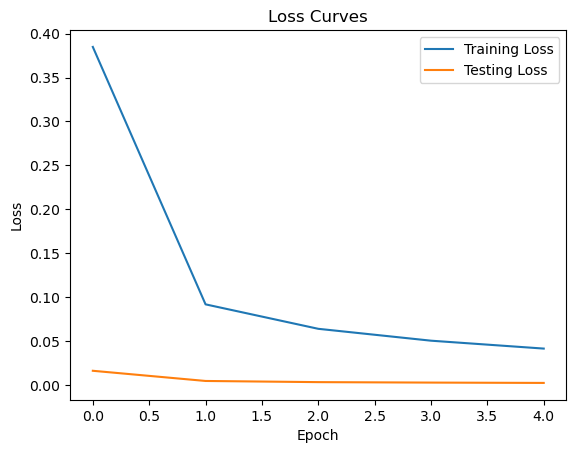

In [12]:
# Plot the loss curve
plt.plot(losses, label='Training Loss')
plt.plot(losses_test, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

In [13]:
accuracy_test = 0

with torch.no_grad():
    for images, labels in tqdm(testloader):
        images, labels = images.to(device), labels.to(device)

        outputs = model_mobileone(images)
        max_indices = torch.argmax(outputs, dim=1)

        accuracy_test += torch.sum(torch.eq(max_indices, labels)).item()

    accuracy_test = accuracy_test / (len(testloader)*64)

print(f"Test Accuracy : {accuracy_test}")

100%|██████████| 62/62 [03:52<00:00,  3.75s/it]

Test Accuracy : 0.969758064516129


In [14]:
torch.save(model_mobileone.state_dict(), "mobileone.pth")